```{index} single: Solvers; Mosek
```
```{index} single: Pyomo; kernel library
```
```{index} single: conic optimization
```
```{index} single: application; support vector machines
```
```{index} single: application; binary classification
```
```{index} single: application; counterfeit banknotes
```
# Extra material: Support Vector Machines with conic optimization

In this notebook we come back to the concept of training support vector machines as we did in [the first SVM notebook](../05/04-svm-binary-classification.ipynb)

The difference is that we shall now be solving the dual problems related to training the SVM's using the conic quadratic optimization by explicitly calling the MOSEK solver, which should yield more stable numerical results than general convex optimization.

The first part of this notebook shall therefore consist of data imports and other things that need no further explanation. Please move directly to the cell entitled "Conic optimization model" if you already have the data loaded from there. 

Point of attention: An important difference with the first notebook will be the fact that we will eliminate the 'intercept' $b$ of the SVM to keep our equations simple.

## Preamble: Install Pyomo and a solver

This cell selects and verifies a global SOLVER for the notebook. If run on Google Colab, the cell installs Pyomo and ipopt, then sets SOLVER to use the ipopt solver. If run elsewhere, it assumes Pyomo and the Mosek solver have been previously installed and sets SOLVER to use the Mosek solver via the Pyomo SolverFactory. It then verifies that SOLVER is available. 

In [1]:
import sys, os

if 'google.colab' in sys.modules:
    %pip install idaes-pse --pre >/dev/null 2>/dev/null
    !idaes get-extensions --to ./bin 
    os.environ['PATH'] += ':bin'
    solver = "ipopt"
else:
    solver = "mosek_direct"

import pyomo.kernel as pmo
import pyomo.environ as pyo 
SOLVER = pmo.SolverFactory(solver)

assert SOLVER.available(), f"Solver {solver} is not available."

## The Data Set 

The following data set contains data from a collection of known genuine and known counterfeit banknote specimens. The data includes four continuous statistical measures obtained from the wavelet transform of banknote images named "variance", "skewness", "curtosis", and "entropy", and a binary variable named "class" which is 0 if genuine and 1 if counterfeit.

https://archive.ics.uci.edu/ml/datasets/banknote+authentication

### Read data

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# read data set
df = pd.read_csv(
    "https://raw.githubusercontent.com/mobook/MO-book/main/datasets/data_banknote_authentication.txt",
    header=None,
)
df.columns = ["variance", "skewness", "curtosis", "entropy", "class"]
df.name = "Banknotes"

### Select features and training sets

Following customary practices, we divide the data set into a **training set** used to trail the classifier, and a **testing set** that will be used to evaluate the performance of the classifier. In addition, we select two dimensional subset of the features to enable plotting of the results for exposition. Since our definition of a positive outcome corresponds to detecting a genuine banknote, we rescale the "class" feature to have values of 1 for genuine banknotes and -1 for counterfeit banknotes. 

In [3]:
# create training and validation test sets
df_train, df_test = train_test_split(df, test_size=0.2)

# select training features
features = ["variance", "skewness"]

# separate into features and outputs
X_train = df_train[features]
y_train = 1 - 2 * df_train["class"]

# separate into features and outputs
X_test = df_test[features]
y_test = 1 - 2 * df_test["class"]

The following cell presents a simple function to create a scatter plot for a labeled 2D set of features. The function assigns default labels and colors, and passes along other keyword arguments.

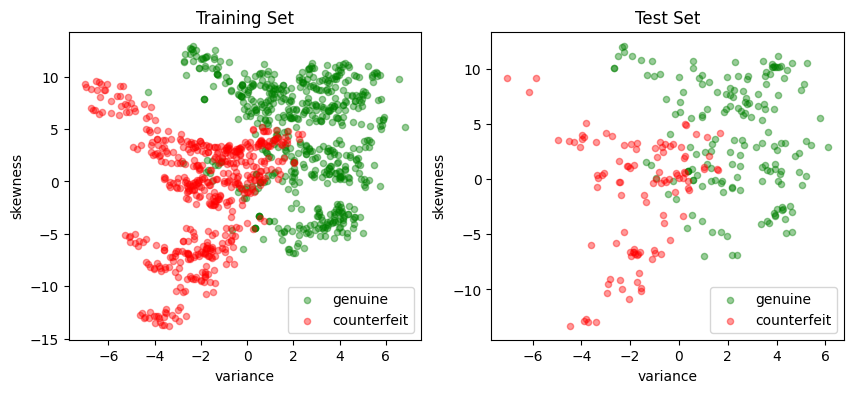

In [4]:
def scatter_labeled_data(X, y, labels=["+1", "-1"], colors=["g", "r"], **kwargs):
    # Prepend keyword arguments for all scatter plots
    kw = {"x": 0, "y": 1, "kind": "scatter", "alpha": 0.4}
    kw.update(kwargs)

    # Ignore warnings from matplotlib scatter plot
    import warnings

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        kw["ax"] = X[y > 0].plot(**kw, c=colors[0], label=labels[0])
        X[y < 0].plot(**kw, c=colors[1], label=labels[1])


# plot training and test sets in two axes
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
scatter_labeled_data(
    X_train,
    y_train,
    labels=["genuine", "counterfeit"],
    ax=ax[0],
    title="Training Set",
)
scatter_labeled_data(
    X_test,
    y_test,
    labels=["genuine", "counterfeit"],
    ax=ax[1],
    title="Test Set",
)

### Performance metrics

The accuracy score alone is not always a reliable metric for evaluating the performance of binary classifiers. For instance, when one outcome is significantly more frequent than the other, a classifier that always predicts the more common outcome without regard to the feature vector can achieve a very high accuracy score while being completely wrong on the less common outcome. 

Moreover, in many applications, the consequences of a false positive can differ from those of a false negative. For these reasons, we seek a more comprehensive set of metrics to compare binary classifiers. 
- Sensitivity of a classifier measures how many of the actually positive items in the dataset have been labelled as positive. 
- Precision, on the other hand, counts how many of the items marked as positive, are actually positive. 

A [detailed discussion on this topic](https://bmcgenomics.biomedcentral.com/articles/10.1186/s12864-019-6413-7) recommends the [Matthews correlation coefficient (MCC)](https://towardsdatascience.com/the-best-classification-metric-youve-never-heard-of-the-matthews-correlation-coefficient-3bf50a2f3e9a) as a reliable performance measure for binary classifiers.

The code below demonstrates an example of a function that evaluates the performance of a binary classifier and returns the Matthews correlation coefficient as its output.

In [5]:
def validate(y_true, y_pred, verbose=True):
    # Calculate the elements of the confusion matrix
    true_positives = sum((y_true > 0) & (y_pred > 0))
    false_negatives = sum((y_true > 0) & (y_pred < 0))
    false_positives = sum((y_true < 0) & (y_pred > 0))
    true_negatives = sum((y_true < 0) & (y_pred < 0))
    total = true_positives + true_negatives + false_positives + false_negatives

    # Calculate the Matthews correlation coefficient (MCC)
    mcc_numerator = (true_positives * true_negatives) - (
        false_positives * false_negatives
    )
    mcc_denominator = np.sqrt(
        (true_positives + false_positives)
        * (true_positives + false_negatives)
        * (true_negatives + false_positives)
        * (true_negatives + false_negatives)
    )
    mcc = mcc_numerator / mcc_denominator

    if verbose:
        print(f"Matthews correlation coefficient (MCC) = {mcc:0.3f}")

        # report sensitivity and precision, and accuracy
        sensitivity = true_positives / (true_positives + false_negatives)
        precision = true_positives / (true_positives + false_positives)
        accuracy = (true_positives + true_negatives) / total

        print(f"Sensitivity = {100 * sensitivity: 0.1f}%")
        print(f"Precision = {100 * precision: 0.1f}%")
        print(f"Accuracy = {100 * accuracy: 0.1f}%")

        # Display the binary confusion matrix
        confusion_matrix = pd.DataFrame(
            [
                [true_positives, false_negatives],
                [false_positives, true_negatives],
            ],
            index=["Actual Positive", "Actual Negative"],
            columns=["Predicted Positive", "Predicted Negative"],
        )
        display(confusion_matrix)

    return mcc

## Conic optimization model

### Primal formulation

As already explained in in [the first support vector machine notebook](../05/04-svm-binary-classification.ipynb), the standard formulation of a linear support vector machine uses training sets with $p$-element feature vectors $x_i\in\mathbb{R}^p$ along with classification labels for those vectors, $y_i = \pm 1$. A classifier is defined by two parameters: a weight vector $w\in\mathbb{R}^p$ and a bias term $b\in\mathbb{R}$

$$
\begin{align*}
     y^{pred} & = \text{sgn}(w^\top x + b)
\end{align*}
$$

We train the classifier by developing and solving an optimization model for the values of $w$ and $b$. The presence of parameter $b$, however, unnecessarily complicates the presentation and derivation of the model. To simplify, we introduce an augmented feature vector $\bar{x} = (1, x) \in \mathbb{R}^{p+1}$ and an augmented weight vector $\bar{w} = (b, w) \in \mathbb{R}^{p+1}$ so the classifier can be presented as

$$
\begin{align*}
y^{pred} & = \text{sgn}(\bar{w}^\top \bar{x})
\end{align*}
$$

Given a value of $\bar{w}$, there is a family of hyperplanes in $\mathbb{R}^{p+1}$ orthogonal to $\bar{w}$. A **separating hyperplane**, if one exists, separates all data points with $y_i = 1$ from those with $y_i = -1$. The distance between $\bar{x}_i$ and the separating  hyperplane is the length of the projection $\bar{x}_i$ onto $\bar{w}$, which is

$$\frac{\bar{w}^\top \bar{x}_i}{\|\bar{w}\|}$$

If a separating hyperplane exists, then we can choose the norm of $\bar{w}$ so that a hard-margin classifier exists for the training set $(\bar{x}_i, y_i)$ where

$$
\begin{align*}
y_i \bar{w}^\top \bar{x}_i & \geq 1 & \forall i \in 1, 2, \dots, n
\end{align*}
$$

Otherwise, if a separating hyperplane does not exist, we introduce non-negative slack variables $z_i$ to relax the constraints and settle for a soft-margin classifier 

$$
\begin{align*}
y_i \bar{w}^\top \bar{x}_i & \geq 1 - z_i& \forall i \in 1, 2, \dots, n
\end{align*}
$$ 

Given $\bar{w}$, training data for which $z_i > 1$ are misclassified. The training objective is to minimize the number and distance to misclassified data points. This leads to the optimization problem

$$
\begin{align*}
\min \quad & \frac{1}{2} \|\bar{w}\|_2^2 + \frac{c}{n}\sum_{i=1}^n z_i \\
\text{s.t.} \quad & z_i \geq 1 - y_i \bar{w}^\top \bar{x}_i & \forall i = 1, 2, \dots, n \\
& z_i  \geq 0 & \forall i = 1, 2, \dots, n
\end{align*}
$$

where $\frac{1}{2} \|\bar{w}\|_2^2$ is included to regularize the solution for $\bar{w}$. Choosing larger values of $c$ will reduce the number and size of misclassifications. The trade-off will be larger weights $\bar{w}$ and the accompanying risk of over over-fitting the training data. 

To simplify the presentation of the model, we introduce an $n \times (p+1)$ matrix $F$ constructed from the training data

$$
\begin{align}
    F & = \begin{bmatrix} y_1\bar{x}_1^\top \\ y_2\bar{x}_2^\top \\ \vdots \\ y_n\bar{x}_n^\top \end{bmatrix}
\end{align}
$$

Next we introduce a **[rotated quadratic cone](https://docs.mosek.com/modeling-cookbook/cqo.html#equation-eq-sec-qo-modeling-qset2)** defined as 

$$\mathcal{Q}^m_r = \{u\in\mathbb{R}^m | 2u_1u_2 \geq u_3^2 + \cdots + u_m^2,\ u_1, u_2 \geq 0 \}$$

and parameter $r$ where 

$$2 r \geq \|\bar{w}\|_2^2 = \bar{w}_1^2 + \bar{w}_2^2 + \cdots + \bar{w}_{p+1}^2$$

With these additional components, the primal problem is now a conic optimization problem ready for implementation with the Pyomo [Kernel Library](https://pyomo.readthedocs.io/en/stable/library_reference/kernel/index.html) and Mosek conic solver.

$$
\begin{align*}
    \min \quad & r + \frac{c}{n} 1^\top z\\
    \text{s.t.}\quad & (r, 1, \bar{w}) \in \mathcal{Q}_r^{3 + p} \\
    & z + F \bar{w} \geq 1  \\
    & z \geq 0 & z\in\mathbb{R}^n \\
    & r\in\mathbb{R} \\
\end{align*}
$$

Like for the previous case, the Pyomo implementation is a "factory" function that returns a linear SVM.

In [6]:
# Linear Support Vector Machine (SVM) class
class LinearSvm:
    # Initialize the Linear SVM with weights and bias
    def __init__(self, w, b):
        self.w = pd.Series(w)
        self.b = float(b)

    # Call method to compute the decision function
    def __call__(self, X):
        return np.sign(X.dot(self.w) + self.b)

    # Representation method for the Linear SVM class
    def __repr__(self):
        return f"LinearSvm(w = {self.w.to_dict()}, b = {self.b})"


def conicSvmFactory(X, y, c=1):
    # create data matrix F
    n, p = X.shape
    F = np.array(
        [y.iloc[i] * np.append(1, X.iloc[i, :].to_numpy()) for i in range(n)]
    )  # Appending 1's to features

    # create model block
    m = pmo.block()

    # decision variables
    m.r = pmo.variable()
    m.w = pmo.variable_list([pmo.variable() for i in range(p + 1)])
    m.z = pmo.variable_list([pmo.variable(lb=0) for i in range(n)])

    # objective
    m.primal = pmo.objective(expr=m.r + (c / n) * sum(m.z))

    # constraints
    m.qr = pmo.conic.rotated_quadratic.as_domain(m.r, 1, m.w)
    m.d = pmo.constraint_list(
        [
            pmo.constraint(
                body=m.z[i] + sum(F[i, j] * m.w[j] for j in range(p + 1)), lb=1
            )
            for i in range(n)
        ]
    )

    # solve
    SOLVER.solve(m)

    # return svm
    b = m.w[0]()
    w = pd.Series({k: m.w[j + 1]() for j, k in enumerate(X.columns)})

    return LinearSvm(w, b)


svm_v2 = conicSvmFactory(X_train, y_train, c=10)
print(svm_v2.w)
print(svm_v2.b)

variance    0.546234
skewness    0.152174
dtype: float64
-0.21435828724315473


The following cell with reveal the performance of this standard SVM.

Matthews correlation coefficient (MCC) = 0.769
Sensitivity =  91.7%
Precision =  90.6%
Accuracy =  89.1%


,Predicted Positive,Predicted Negative
Actual Positive,155,14
Actual Negative,16,90


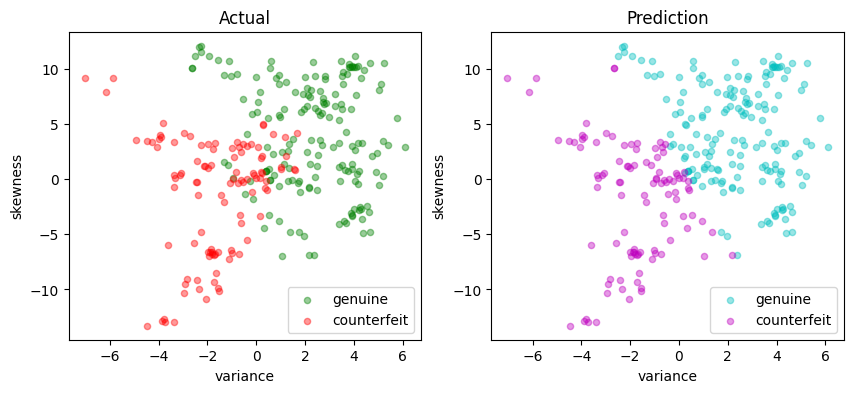

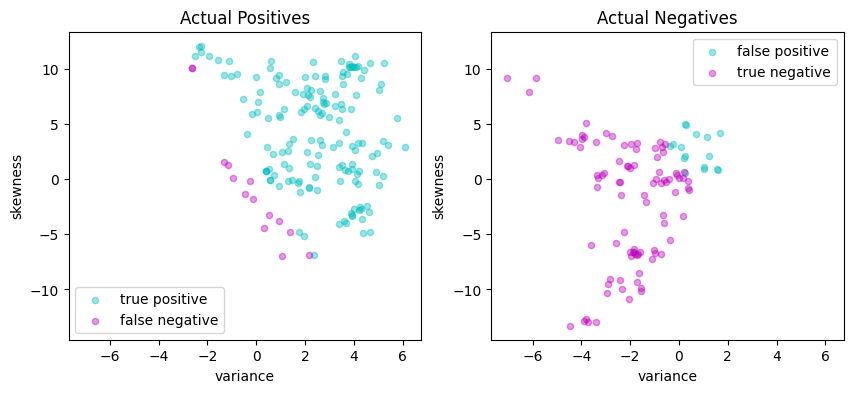

In [7]:
def scatter_comparison(X, y, y_pred):
    xmin, ymin = X.min()
    xmax, ymax = X.max()
    xlim = [xmin - 0.05 * (xmax - xmin), xmax + 0.05 * (xmax - xmin)]
    ylim = [ymin - 0.05 * (ymax - ymin), ymax + 0.05 * (ymax - ymin)]

    # Plot training and test sets
    labels = ["genuine", "counterfeit"]
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    scatter_labeled_data(
        X, y, labels, ["g", "r"], ax=ax[0], xlim=xlim, ylim=ylim, title="Actual"
    )
    scatter_labeled_data(
        X,
        y_pred,
        labels,
        ["c", "m"],
        ax=ax[1],
        xlim=xlim,
        ylim=ylim,
        title="Prediction",
    )

    # Plot actual positives and actual negatives
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    scatter_labeled_data(
        X[y > 0],
        y_pred[y > 0],
        ["true positive", "false negative"],
        ["c", "m"],
        xlim=xlim,
        ylim=ylim,
        ax=ax[0],
        title="Actual Positives",
    )
    scatter_labeled_data(
        X[y < 0],
        y_pred[y < 0],
        ["false positive", "true negative"],
        ["c", "m"],
        xlim=xlim,
        ylim=ylim,
        ax=ax[1],
        title="Actual Negatives",
    )


y_pred = svm_v2(X_test)
validate(y_test, y_pred)
scatter_comparison(X_test, y_test, y_pred)

### Dual formulation

As we already know, the dual of our problem shall be given by
$$
\begin{align*}
\min \quad & \frac{1}{2} \sum_{i=1}^n\sum_{j=1}^n \alpha_i \alpha_j y_i y_j ( \bar{x}_i^\top \bar{x}_j ) -  \sum_{i=1}^n \alpha_i \\
\text{s.t.}\quad & \alpha_i \in \left[0, \frac{c}{n}\right] & i = 1, \dots, n. \\
\end{align*}
$$

The symmetric $n \times n$ **Gram matrix** is defined as

$$
    G = \begin{bmatrix} 
        (y_1\bar{x}_1^\top)(y_1\bar{x}_1) & \dots & (y_1\bar{x}_1^\top)(y_n\bar{x}_n) \\ 
        \vdots & \ddots & \vdots \\ 
        (y_n\bar{x}_n^\top)(y_1\bar{x}_1) & \dots & (y_n\bar{x}_n^\top)(y_n\bar{x}_n)
    \end{bmatrix}
$$

where each entry is dot product of two vectors $(y_i\bar{x}_i), (y_j\bar{x}_j) \in \mathbb{R}^{p+1}$. 

Compared to the primal, the dual formulation appears to have reduced the number of decision variables from $n + p + 1$ to $n$. But this has come with the penalty of introducing a dense matrix with $n^2$ coefficients and potential processing time of order $n^3$. For large training sets where $n\sim 10^4-10^6$ or even larger, this becomes a prohibitively expensive calculation. In addition, the Gram matrix will be rank deficient for cases $p+1 < n$. 

Reformulating the dual problem as a conic optimization problem eliminates the need to compute and store the full Gram matrix $G$. The reformulation begins by use the $n \times (p+1)$ matrix $F$ previously introduced in the primal problem:

$$
    F = \begin{bmatrix} y_1 \bar{x}_1^\top \\ y_2 \bar{x}_2^\top \\ \vdots \\ y_n \bar{x}_n^\top \end{bmatrix}
$$

Then $G = FF^\top$ and the optimization problem becomes

$$
\begin{align*}
\min\quad & \frac{1}{2} \alpha^\top F F^\top \alpha -  1^\top \alpha \\
\text{s.t.}\quad & 0 \leq \alpha \leq \frac{c}{n} & \alpha\in\mathbb{R}^n \\
\end{align*}
$$

We introduce an additional decision variable $r \geq 0$ to specify rotated quadratic cones. Let $z = F^\top\alpha$, then

$$\alpha^\top F F^\top \alpha \leq 2 r \iff z^\top z \leq 2 r \iff (r, 1, z) \in Q_r^{3 + p}$$

The result is a conic optimization problem for the dual coefficients $\alpha$ and auxiliary variables $r$ and $z$.

$$
\begin{align*}
\min \quad & r - 1^\top \alpha\\
\text{s.t.} \quad & (r, 1, z) \in \mathcal{Q}_r^{3 + p} & r\in\mathbb{R} \\
& z = F^\top \alpha & z\in\mathbb{R}^{p+1} \\
& 0 \leq \alpha \leq \frac{c}{n} & \alpha\in\mathbb{R}^n \\
\end{align*}
$$

The solution to dual formulation provides an alternative expression for the resulting support vector machine. Let ${SV}$ represent the set of **support vectors**, which can be implemented as the set of indices for which $\alpha_i > 0$. 
Then SVM can be expressed as either

$$
\begin{align}
y^{pred} & = \text{sgn}\left( \bar{w}^\top \bar{x} \right)\quad
\text{where}\quad \bar{w} = \sum_{i\in\cal{SV}} \alpha_i y_i \bar{x}_i 
\end{align}
$$

or, more directly, as

$$
\begin{align}
y^{pred} & =  \text{sgn}\left( \sum_{i\in\cal{SV}} \alpha_i y_i \bar{x}_i^\top \bar{x} \right)
\end{align}
$$

The first formulation is a computationally efficient implementation of a linear SVM, and used in the following Pyomo implementation. The second formulation, however, provides additional insight into how an SVM works, and is the basis for important generalizations of SVM including the kernelized SVM discussed below. Remember, we no longer need to derive the value of the primal variable $b$ because we eliminated its existence by stacking 1's into the feature vector.

The following code implements the above SVM dual formulation.

### Pyomo implementation

variance    0.546247
skewness    0.152194
dtype: float64 -0.21435778397469038


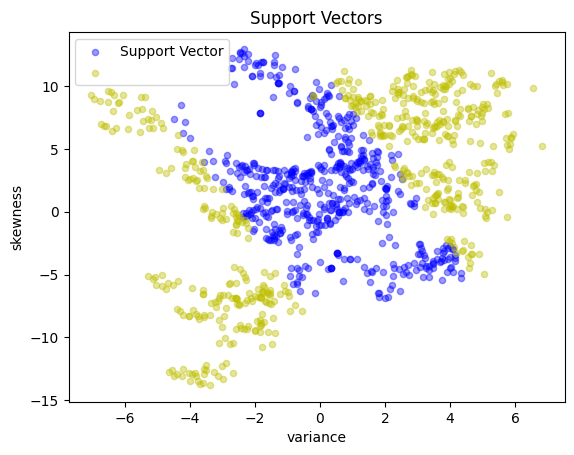

In [8]:
def conicDualSVMFactory(X, y, c=1):
    n, p = X.shape
    F = np.array(
        [y.iloc[i] * np.append(1, X.iloc[i, :].to_numpy()) for i in range(n)]
    )  # Appending 1's to features

    m = pmo.block()

    # decision variables
    m.r = pmo.variable()
    m.a = pmo.variable_list([pmo.variable(lb=0, ub=c / n) for i in range(n)])
    m.z = pmo.variable_list([pmo.variable() for i in range(p + 1)])

    # objective
    m.o = pmo.objective(expr=m.r - sum(m.a))

    # constraints
    m.d = pmo.constraint_list(
        [
            pmo.constraint(body=sum(F[i, j] * m.a[i] for i in range(n)) - m.z[j], rhs=0)
            for j in range(p + 1)
        ]
    )
    m.q = pmo.conic.rotated_quadratic.as_domain(m.r, 1, m.z)

    # solve
    SOLVER.solve(m)

    # get the support
    S = [i for i in range(n) if (m.a[i]() > 0)]

    # create and return linear SVM
    w_bar = sum(m.a[i]() * F[i, :] for i in S)
    w = pd.Series({k: w_bar[j + 1] for j, k in enumerate(X.columns)})
    b = w_bar[0]

    y_support = pd.Series([1 if m.a[i]() > 0 else -1 for i in range(n)], index=X.index)
    scatter_labeled_data(
        X,
        y_support,
        colors=["b", "y"],
        labels=["Support Vector", ""],
        title="Support Vectors",
    )

    return LinearSvm(w, b)


svm_v3 = conicDualSVMFactory(X_train, y_train, c=10)
print(svm_v3.w, svm_v3.b)

The following cell implements the above conic dual formulation and should obtain exactly the same accuracy results.

Matthews correlation coefficient (MCC) = 0.769
Sensitivity =  91.7%
Precision =  90.6%
Accuracy =  89.1%


,Predicted Positive,Predicted Negative
Actual Positive,155,14
Actual Negative,16,90


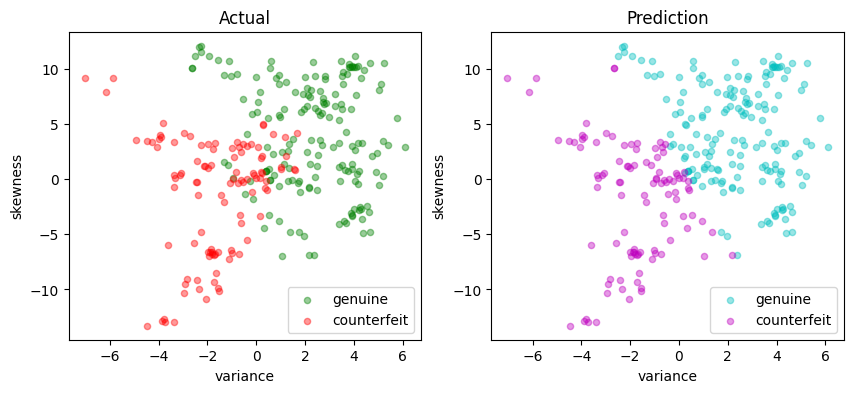

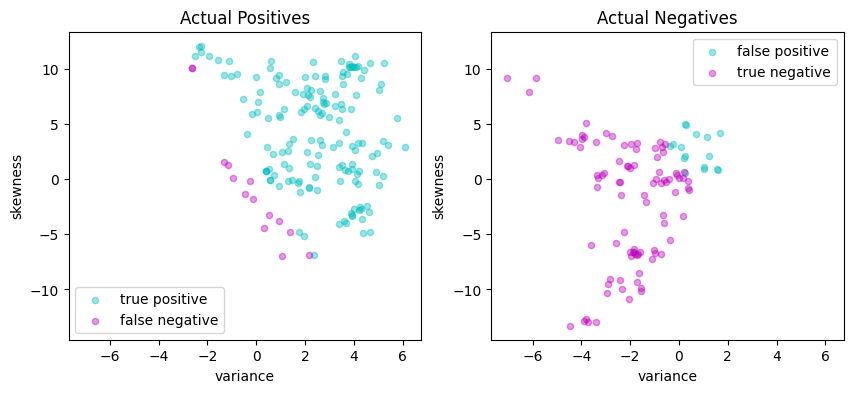

In [9]:
y_pred = svm_v3(X_test)
validate(y_test, y_pred)
scatter_comparison(X_test, y_test, y_pred)

## Kernelized SVM

### Nonlinear feature spaces

A linear SVM assumes the existence of a linear hyperplane that separates labeled sets of data points. Frequently, however, this is not possible and some sort of nonlinear method where the feature vector is appended with nonlinear transformations 

$$
\bar{x} \rightarrow \phi(\bar{x})
$$

where $\phi(\bar{x})$ is a function mapping $x$ into a higher dimensional "feature space". That is, $\phi : \mathbb{R}^{p + 1} \rightarrow \mathbb{R}^d$ where $d \geq p +1 $. The additional dimensions may include features such as powers of the terms in $x$, or products of those terms, or other types of nonlinear transformations. In this way, the SVM has more 'room to play' in order to try to separate one point from another. 

Corresponding to such a transformed vector, we have a binary classification tool given by

$$
y^{pred} = \text{sgn} \left( w^\top \phi(\bar{x}) \right).
$$

From now onwards, the derivation of the dual problem goes exactly the same way as in the linear SVM case (please refer to [the first support vector machine notebook](../05/04-svm-binary-classification.ipynb)), and we arrive at:

$$
\begin{align*}
\min \ & \frac{1}{2} \sum_{i=1}^n\sum_{j=1}^n \alpha_i \alpha_j y_i y_j  \phi(\bar{x}_i)^\top \phi(\bar{x}_j) -  \sum_{i=1}^n \alpha_i \\
\text{s. t.}\quad & \alpha_i \in \left[0, \frac{c}{n}\right] & i = 1, \dots, n \\
\end{align*}
$$

### The kernel trick

If you look at the optimization problem above and the corresponding classifier tool, this is an interesting situation where the separating hyperplane is embedded in a high dimensional space of nonlinear features determined by the mapping $\phi(\bar{x})$, but all we need to train the classifier and to use the classifier are the inner products  $\phi(\bar{x}_i)^\top\phi(\bar{x}_j)$ and $\phi(\bar{x}_i)^\top\phi(x)$, rather than the 'raw' $\phi(\bar{x}_i)$ and $\phi(\bar{x})$ values. If we had a function $K(\bar{x}, \bar{z})$ that returned the value $\phi(\bar{x})^\top\phi(\bar{z})$ then we would never need to actually compute $\phi(\bar{x})$, $\phi(\bar{z})$ or their inner product.

Mercer's theorem turns the analysis on its head by specifying conditions for which a function $K(\bar{x}, \bar{z})$ to be expressed as an inner product for some $\phi(x)$. If $K(\bar{x}, z)$ is symmetric (i.e, $K(\bar{x}, \bar{z}) = K(\bar{z}, \bar{x})$, and if the Gram matrix constructed for any collection of points $x_1, x_2, \ldots, x_n$ 

$$
\begin{bmatrix} 
    K(\bar{x}_1, \bar{x}_1) & \dots & K(\bar{x}_1, \bar{x}_n) \\ 
    \vdots & \ddots & \vdots \\ 
    K(\bar{x}_n, \bar{x}_1) & \dots & K(\bar{x}_n, \bar{x}_n) 
\end{bmatrix}
$$

is positive semi-definite, then there is some $\phi(\bar{x})$ for which $K(\bar{x}, \bar{z})$ is an inner product. We call such functions kernels. The practical consequence is that we can train and implement nonlinear classifiers using kernel and without ever needing to compute the higher dimensional features. This remarkable result is called the "kernel trick".

### Implementation

To take advantage of the kernel trick, we assume an appropriate kernel $K(\bar{x}, \bar{z})$ has been identified, then replace all instances of $\phi(\bar{x_i})^\top \phi(\bar{x})$ with the kernel. The "kernelized" SVM is then given by solution to 

$$
\begin{align*}
\min \ & \frac{1}{2} \sum_{i=1}^n\sum_{j=1}^n \alpha_i \alpha_j y_i y_j K(\bar{x}_i, \bar{x}_j) -  \sum_{i=1}^n \alpha_i \\
\text{s. t.}\quad & \alpha_i \in \left[0, \frac{c}{n}\right] & i = 1, \dots, n \\
\end{align*}
$$

where the resulting classifier is given by 

$$y^{pred} = \text{sgn} \left( \sum_{i=1}^n \alpha_iK(\bar{x}_i, \bar{x}) \right)$$

We define the $n\times n$ positive symmetric semi-definite Gram matrix

$$
G = \begin{bmatrix} 
    y_1 y_1 K(\bar{x}_1, \bar{x}_1) & \dots & y_1 y_nK(\bar{x}_1, \bar{x}_n) \\ 
    \vdots & \ddots & \vdots \\ 
    y_n y_1 K(\bar{x}_n, \bar{x}_1) & \dots & y_n y_n K(\bar{x}_n, \bar{x}_n) 
\end{bmatrix}
$$

We factor $G = FF^\top$ where $F$ has dimensions $n \times q$ and where $q$ is the rank of $G$. This factorization is not unique. As demonstrated in the Python code below, one suitable factorization is the spectral factorization $G = U\Lambda U^T$ where $\Lambda$ is a $q\times q$ diagonal matrix of non-zero eigenvalues, and $U$ is an $n\times q$ normal matrix such that $U^\top U = I_q$. Then

$$F = U\Lambda^{1/2}$$

Once this factorization is complete, the optimization problem for the kernalized SVM is the same as for the linear SVM in the dual formulation

$$
\begin{align*}
\min\quad & \frac{1}{2} \alpha^\top F F^\top \alpha -  1^\top \alpha \\
\text{s.t.}\quad & 0 \leq \alpha \leq \frac{c}{n} & \alpha\in\mathbb{R}^n \\
\end{align*}
$$

The result is a conic program for the dual coefficients $\alpha$ and auxiliary variables $r$ and $z$.

$$
\begin{align*}
\min \quad & r - 1^\top \alpha\\
\text{s.t.} \quad & (r, 1, z) \in \mathcal{Q}_r^{2 + q} & r\in\mathbb{R} \\
& z = F^\top \alpha & z\in\mathbb{R}^{q} \\
& 0 \leq \alpha \leq \frac{c}{n} & \alpha\in\mathbb{R}^n \\
\end{align*}
$$

Summarizing, the essential difference between training the linear and kernelized SVM is the need to compute and factor the Gram matrix. The result will be a set of non-zero coefficients $\alpha_i > 0$ the define a set of support vectors $\mathcal{SV}$. The classifier is then given by

$$y^{pred} = \text{sgn} \left( \sum_{i\in\mathcal{SV}} \alpha_iK(\bar{x}_i, \bar{x}) \right)$$

The following cell implements this model, leaving it to the user to specify the kernel function via a lambda-function argument.

In [10]:
def kernelSVMFactory(X, y, c, tol=1e-8, kernel=lambda x, z: (x @ z)):
    n, p = X.shape

    # convert to numpy arrays for speed
    X_ = np.hstack([np.ones((n, 1)), X.to_numpy()])
    y_ = y.to_numpy()

    # kernel matrix
    G = [
        [y_[i] * y_[j] * kernel(X_[i, :], X_[j, :]) for j in range(n)] for i in range(n)
    ]

    # spectral factors for a positive semi-definite matrix
    eigvals, V = np.linalg.eigh(G)
    idx = eigvals >= tol * max(eigvals)
    F = V[:, idx] @ np.diag(np.sqrt(eigvals[idx]))
    q = sum(idx)

    # build model
    m = pmo.block()

    # decision variables
    m.r = pmo.variable()
    m.a = pmo.variable_list([pmo.variable(lb=0, ub=c / n) for i in range(n)])
    m.z = pmo.variable_list([pmo.variable() for i in range(q)])

    # objective
    m.o = pmo.objective(expr=m.r - sum(m.a))

    # constraints
    m.d = pmo.constraint_list(
        [
            pmo.constraint(body=sum(F[i, j] * m.a[i] for i in range(n)) - m.z[j], rhs=0)
            for j in range(q)
        ]
    )
    m.q = pmo.conic.rotated_quadratic.as_domain(m.r, 1, m.z)

    # solve
    SOLVER.solve(m)

    y_support = pd.Series(
        [1 if m.a[i]() > 1e-3 * c / n else -1 for i in range(n)], index=X.index
    )
    scatter_labeled_data(
        X,
        y_support,
        colors=["b", "y"],
        labels=["Support Vector", ""],
        title="Support Vectors",
    )

    # get indices of the support vectors
    SV = [i for i in range(n) if (m.a[i]() > 1e-3)]

    def kernelSVM(Z):
        nz, pz = Z.shape
        Z_ = np.hstack([np.ones((nz, 1)), Z.to_numpy()])
        y_pred = pd.Series(
            [
                np.sign(sum(m.a[i]() * y_[i] * kernel(X_[i, :], Z_[j, :]) for i in SV))
                for j in range(nz)
            ],
            index=Z.index,
        )
        return y_pred

    return kernelSVM

### Linear kernel

A linear kernel reduces the kernelized SVM to the previous case. 

$$K(x, z) = x^\top z$$

This is useful for verifying the calculation because we can check if we obtain indeed the same results.

Matthews correlation coefficient (MCC) = 0.762
Sensitivity =  91.1%
Precision =  90.6%
Accuracy =  88.7%


,Predicted Positive,Predicted Negative
Actual Positive,154,15
Actual Negative,16,90


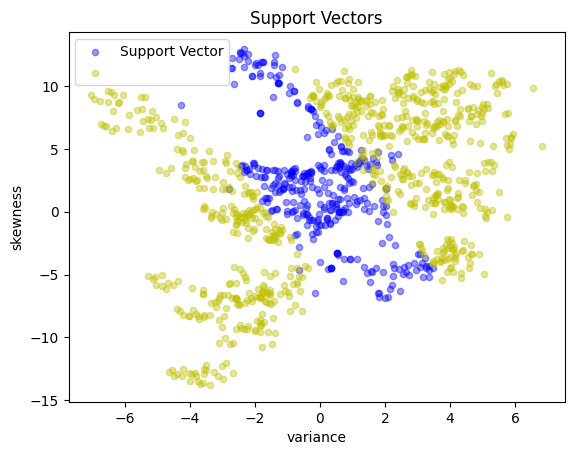

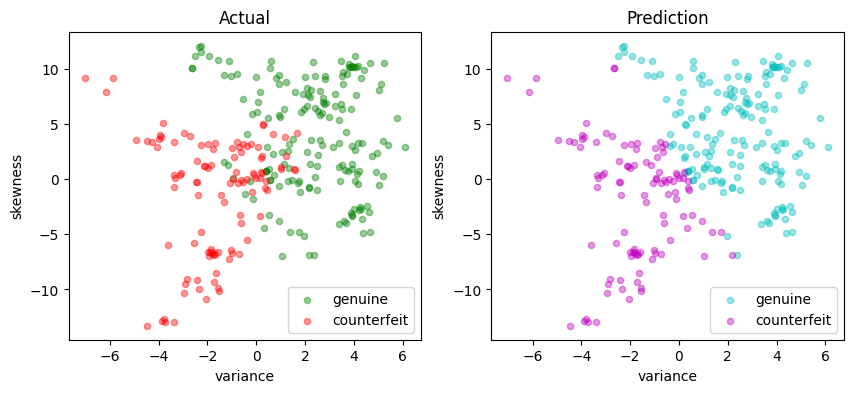

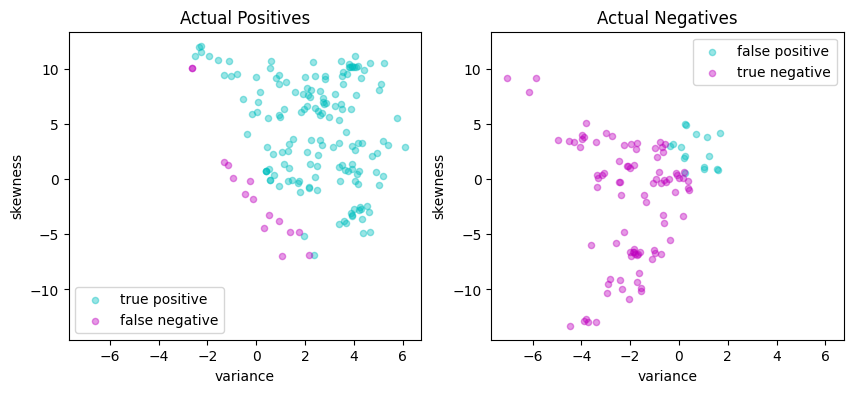

In [11]:
svm = kernelSVMFactory(X_train, y_train, c=10, kernel=lambda x, z: x @ z)

y_pred = svm(X_test)
validate(y_test, y_pred)
scatter_comparison(X_test, y_test, y_pred)

### Radial basis function kernel

A radial basis function kernal is given by

$$K(x, z) = \exp\left(-\gamma \|x - z\|^2\right)$$

The radial basis function is commonly used as the default kernel in SVM applications and as we shall see, it can give a significant boost to the predictive performance of our tool.

Matthews correlation coefficient (MCC) = 0.881
Sensitivity =  92.9%
Precision =  97.5%
Accuracy =  94.2%


,Predicted Positive,Predicted Negative
Actual Positive,157,12
Actual Negative,4,102


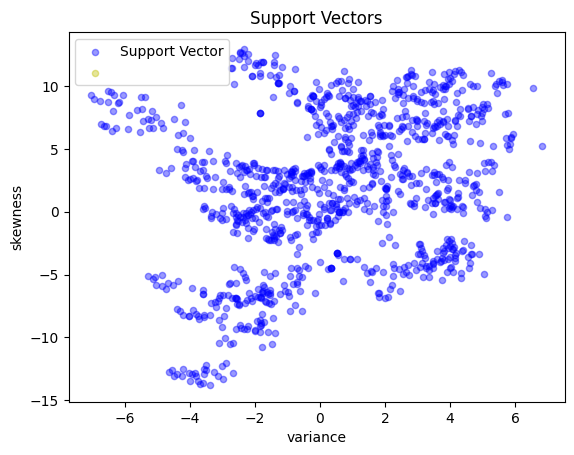

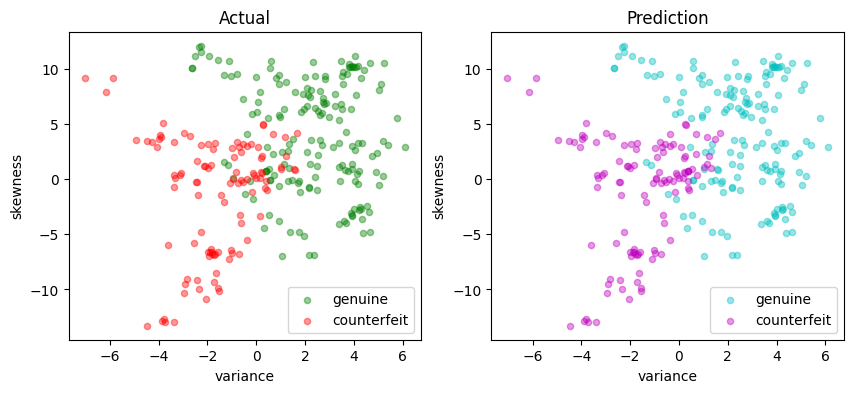

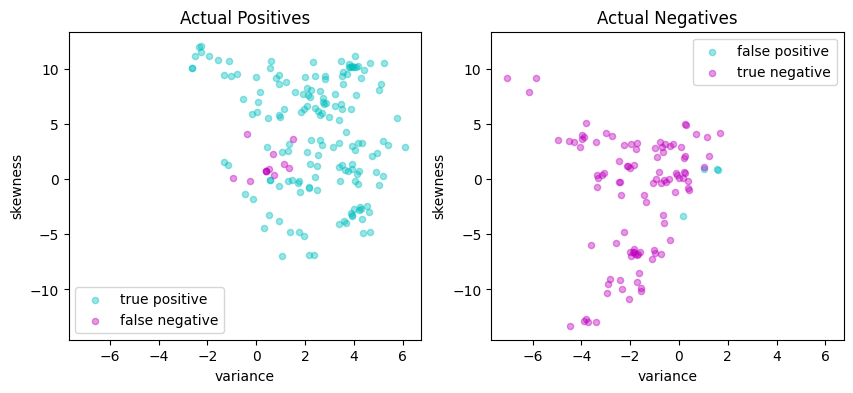

In [12]:
rbf = lambda x, z: np.exp(-10 * np.linalg.norm(x - z) ** 2)
svm = kernelSVMFactory(X_train, y_train, c=10, kernel=rbf)

y_pred = svm(X_test)
validate(y_test, y_pred)
scatter_comparison(X_test, y_test, y_pred)

### Polynomial kernel

Another important kernel function type is the polynomial kernel (which corresponds to including in the feature vector the powers of all featurs up to a certain degree $d$).
$$K(x, z) = (1 + x^\top z)^d$$
Again, the higher the value of $d$, the more predictive power we can expect from the corresponding SVM, therefore, we encourage you to try this formulation varying $d$.

Matthews correlation coefficient (MCC) = 0.438
Sensitivity =  47.3%
Precision =  93.0%
Accuracy =  65.5%


,Predicted Positive,Predicted Negative
Actual Positive,80,89
Actual Negative,6,100


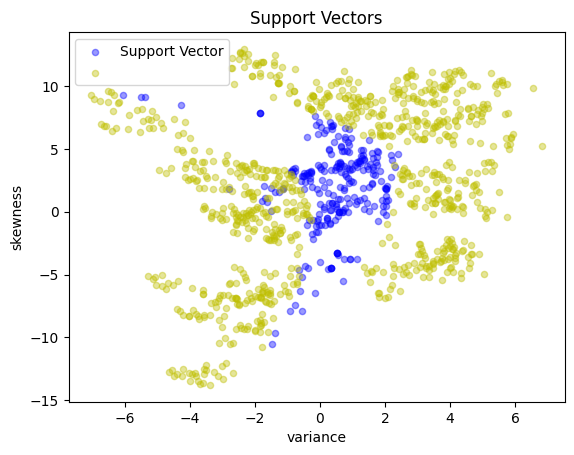

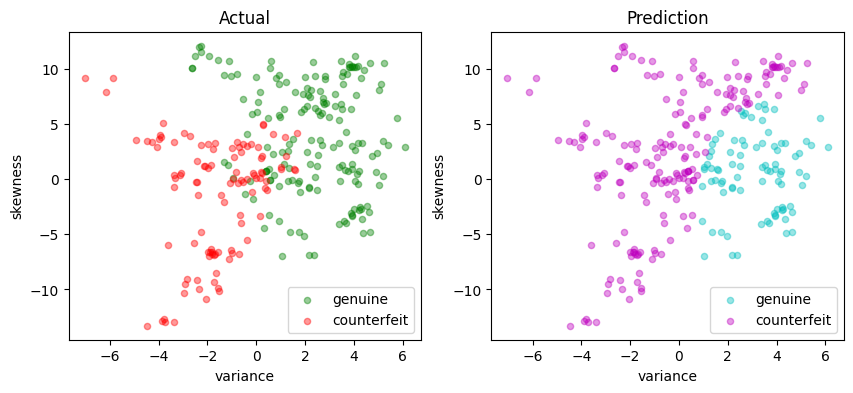

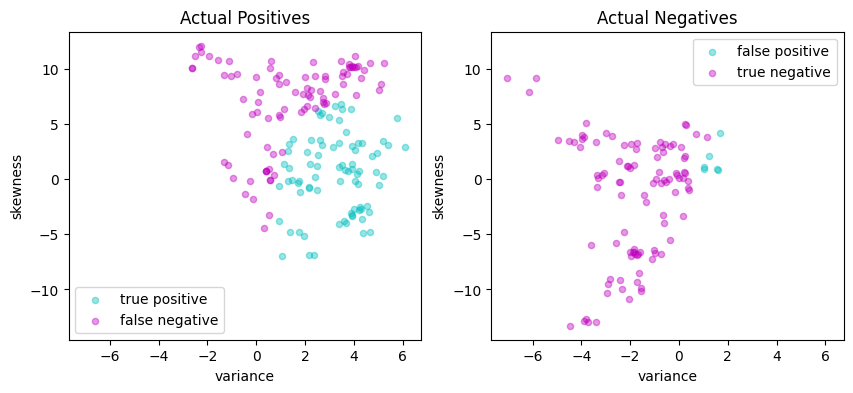

In [13]:
poly = lambda x, z: (1 + (x @ z)) ** 2

svm = kernelSVMFactory(X_train, y_train, c=10, kernel=poly)

y_pred = svm(X_test)
validate(y_test, y_pred)
scatter_comparison(X_test, y_test, y_pred)